In [3]:
import sys
sys.path.append('../fair_regression')

import h5py
import torch
from torch.autograd import Variable

from FairLogReg import FairLogisticRegression
from DataPreprocessing import get_adult_data


def train_split(x, y, pct):
    nsamples = len(y)
    nsamples_val = int(pct * nsamples)
    srs = torch.utils.data.sampler.SubsetRandomSampler(range(nsamples))
    idxs = []
    for n, i in enumerate(srs):
        idxs.append(i)
        if n == nsamples_val - 1:
            x_val = x[idxs]
            y_val = y[idxs]
            idxs = []
    x = x[idxs]
    y = y[idxs]

    return x, y, x_val, y_val

In [6]:
# Import data as pandas dataframes
s_id = ['Sex_Female']
s, x_train, y_train, x_test, y_test = get_adult_data(s_id)

# # Save the header info before turning into matrices
# x_cols = x_train.columns
# y_cols = y_train.columns

# Convert the dataframes into PyTorch variables and cuda-fy if available
x_train = Variable(torch.from_numpy(x_train.as_matrix()))
y_train = Variable(torch.from_numpy(y_train.as_matrix()).long())
x_test = Variable(torch.from_numpy(x_test.as_matrix()))

if torch.cuda.is_available():
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    x_test = x_test.cuda()

# We'll only compare y_test as a numpy array, so don't bother to convert
y_test = y_test.as_matrix()

In [7]:
flr = FairLogisticRegression(l_fair=0.06, validate=0.2, print_freq=1, ftol=1e-7,
                             penalty_type='individual', minibatch_size=512,
                             batch_fairness=True, n_epochs=256)

In [9]:
flr.fit(x_train, y_train, s)

Epoch [1/256] Training    CE Loss: 0.43556   Accuracy: 0.80341   Penalty: 0.64862
              Validation  CE Loss: 0.45542   Accuracy: 0.80467   Penalty: 0.76008
Epoch [2/256] Training    CE Loss: 0.42876   Accuracy: 0.8026   Penalty: 0.59651
              Validation  CE Loss: 0.44821   Accuracy: 0.80421   Penalty: 0.72125
Epoch [3/256] Training    CE Loss: 0.42753   Accuracy: 0.80437   Penalty: 0.61747
              Validation  CE Loss: 0.44672   Accuracy: 0.80743   Penalty: 0.74895
Epoch [4/256] Training    CE Loss: 0.42744   Accuracy: 0.80537   Penalty: 0.62724
              Validation  CE Loss: 0.44627   Accuracy: 0.80805   Penalty: 0.76348
Epoch [5/256] Training    CE Loss: 0.4275   Accuracy: 0.80544   Penalty: 0.63122
              Validation  CE Loss: 0.4461   Accuracy: 0.80881   Penalty: 0.77033
Epoch [6/256] Training    CE Loss: 0.42758   Accuracy: 0.80556   Penalty: 0.63321
              Validation  CE Loss: 0.44603   Accuracy: 0.80912   Penalty: 0.77413
Epoch [7/256] Train

Epoch [51/256] Training    CE Loss: 0.4287   Accuracy: 0.80924   Penalty: 0.65221
              Validation  CE Loss: 0.44621   Accuracy: 0.81496   Penalty: 0.79956
Epoch [52/256] Training    CE Loss: 0.4287   Accuracy: 0.80928   Penalty: 0.65227
              Validation  CE Loss: 0.44621   Accuracy: 0.81496   Penalty: 0.79965
Epoch [53/256] Training    CE Loss: 0.42871   Accuracy: 0.80928   Penalty: 0.65233
              Validation  CE Loss: 0.44622   Accuracy: 0.81496   Penalty: 0.79973
Epoch [54/256] Training    CE Loss: 0.42872   Accuracy: 0.80932   Penalty: 0.65238
              Validation  CE Loss: 0.44622   Accuracy: 0.81496   Penalty: 0.7998
Epoch [55/256] Training    CE Loss: 0.42872   Accuracy: 0.80932   Penalty: 0.65243
              Validation  CE Loss: 0.44622   Accuracy: 0.81496   Penalty: 0.79987
Epoch [56/256] Training    CE Loss: 0.42873   Accuracy: 0.80932   Penalty: 0.65248
              Validation  CE Loss: 0.44622   Accuracy: 0.81511   Penalty: 0.79994
Epoch [57/256

Epoch [101/256] Training    CE Loss: 0.42881   Accuracy: 0.80951   Penalty: 0.65314
              Validation  CE Loss: 0.44625   Accuracy: 0.81465   Penalty: 0.80093
Epoch [102/256] Training    CE Loss: 0.42881   Accuracy: 0.80951   Penalty: 0.65314
              Validation  CE Loss: 0.44625   Accuracy: 0.81465   Penalty: 0.80093
Epoch [103/256] Training    CE Loss: 0.42881   Accuracy: 0.80951   Penalty: 0.65314
              Validation  CE Loss: 0.44625   Accuracy: 0.81465   Penalty: 0.80093
Epoch [104/256] Training    CE Loss: 0.42881   Accuracy: 0.80951   Penalty: 0.65315
              Validation  CE Loss: 0.44625   Accuracy: 0.81465   Penalty: 0.80094


In [16]:
y_pred = flr.predict(x_test).data.cpu().numpy()
y_probas = torch.nn.Softmax(dim=1)(flr.model.forward(x_test)).data.cpu().numpy()

In [18]:
from sklearn.metrics import roc_auc_score, mean_squared_error
mean_squared_error(y_test, y_pred)

0.1888704625023033

In [31]:
roc_auc_score(y_test, y_probas[:, 1])

0.8889499552639926

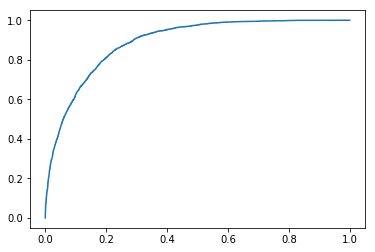

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

curve = roc_curve(y_test, y_probas[:, 1])

plt.plot(*curve[:2])